# **Brain Tumor MR Image Classification**

In this model we have constructed the CNN by implementing blocks of sequential layers using Keras module.

In [0]:
 # Import resources
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import imutils
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
import PIL
from tensorflow.keras.utils import plot_model
import sklearn.metrics
from sklearn.metrics import confusion_matrix
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
# shutil.rmtree('./MRI_data_keras')

Import the data from MRI_data.zip

Here the data is provided in two folders containing 'Yes' and 'No' images specifying whether the brain images have tumor or not.

In [0]:
!unzip -qq MRI_data_keras.zip

Sample Brain MR Image with Tumor

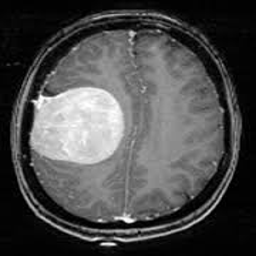

In [0]:
PIL.Image.open('./MRI_data_keras/yes/Y1.jpg').resize((256,256))

Sample Brain MR Image without Tumor

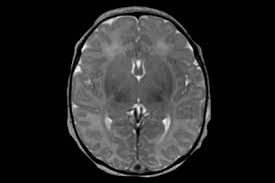

In [0]:
PIL.Image.open('./MRI_data_keras/no/12 no.jpg')

# Image Preprocessing

[link text](https://)Step 1: Cropping the Images along the contours and Gaussian Blurring

In [0]:
def load_edge_crop(filename):

    images = list()
    for fname in os.listdir(filename):
        img = cv2.imread(filename + '/' + fname,0)
        img = cv2.GaussianBlur(img, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(img, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        new_img = img[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()
        new_img = cv2.resize(new_img,dsize=(32,32))
        images.append(new_img)

    shutil.rmtree(filename)
    os.mkdir(filename)

    for index,img in enumerate(images):
        cv2.imwrite(filename + '/' + str(index) + '.jpg',img)


# Loading the processed images into their respective folders
load_edge_crop('./MRI_data_keras/yes')
load_edge_crop('./MRI_data_keras/no')

Step 2: Loading Data into a list and Setting the target variable

In [0]:
#os.chdir("./MRI_data_keras")
yes=os.listdir("./MRI_data_keras/yes")
no=os.listdir("./MRI_data_keras/no")
no=no[:len(no)-1]
data=np.concatenate([yes,no])


valid_x=np.full(len(yes),1)
valid_y=np.full(len(no),0)
valid_data=np.concatenate([valid_x,valid_y])

Distribution of Classes in Brain Images

[Text(0, 0.5, 'Image Count'), Text(0.5, 0, 'Image Classes')]

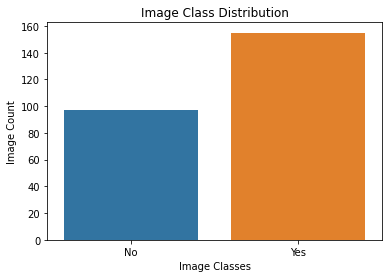

In [0]:
df = pd.DataFrame() 
cnt_data = {'x':['No','Yes'], 
            'y':[len(no),len(yes)]}
df = pd.DataFrame(cnt_data) 

ax=sns.barplot(x='x',y='y',data=df)
ax.set_title("Image Class Distribution")
ax.set(xlabel="Image Classes", ylabel = "Image Count")

Step 3: Image Transformation into Tensors

In [0]:
image_data=[]
for file in yes:
    img_yes = cv2.imread("./MRI_data_keras/yes/"+file)
    image_data.append(img_yes)

for file in no:
    img_no = cv2.imread("./MRI_data_keras/no/"+file)
    image_data.append(img_no)

Step 4: Displaying sample images after pre-processing

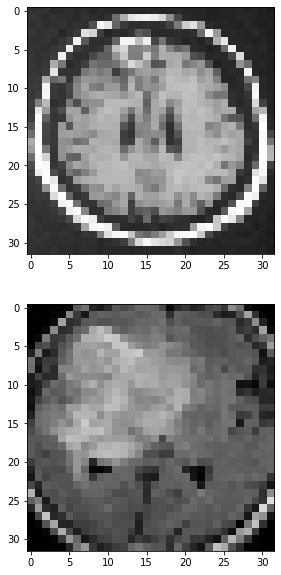

In [0]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(image_data[1])

plt.subplot(212)
plt.imshow(image_data[100])
plt.show()

Squeezing and Normalizing the image tensors

In [0]:
processed_data = np.squeeze(image_data)
processed_data = processed_data.astype('float32')
processed_data /= 255
print(processed_data.shape)

(252, 32, 32, 3)


Splitting Data into train and test sets

In [0]:
(x_train, y_train), (x_test, y_test) = (processed_data[:200],valid_data[:200]) , (processed_data[200:] , valid_data[200:])
(x_test , y_test) = (x_test[:52], y_test[:52])

Model Building-Convolutional Neural Network in Keras 

In [0]:
cnn_model = tf.keras.Sequential()

cnn_model.add(layers.Conv2D(filters=16,kernel_size=9, padding='same', activation='relu', input_shape=(32,32,3))) 
cnn_model.add(layers.MaxPooling2D(pool_size=2))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.Dropout(0.45))

cnn_model.add(layers.Conv2D(filters=16,kernel_size=9,padding='same', activation='relu'))
cnn_model.add(layers.MaxPooling2D(pool_size=2))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.Dropout(0.25))

cnn_model.add(layers.Conv2D(filters=36, kernel_size=9, padding='same', activation='relu'))
cnn_model.add(layers.MaxPooling2D(pool_size=2))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.Dropout(0.25))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dropout(0.15))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

Summary of the CNN Model 

In [0]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        3904      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 16)        64        
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        20752     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 16)          6

Structure of CNN Model

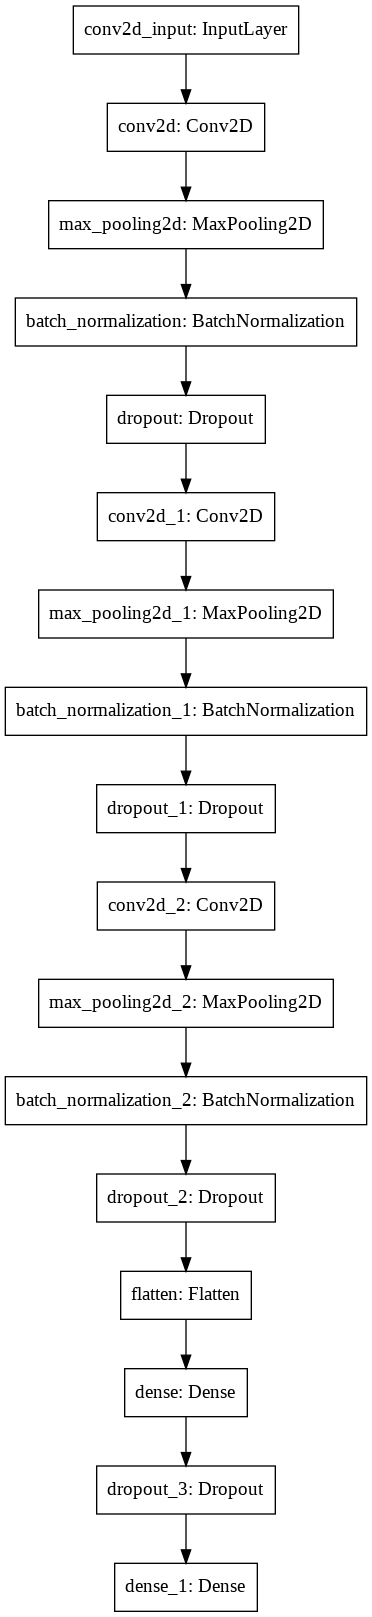

In [0]:
plot_model(cnn_model)

Specifying Optimizer and Loss Functions

In [0]:
cnn_model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['acc'])

Training the CNN model with trainset of brain images

In [0]:
cnnhist=cnn_model.fit(x_train,
         y_train,
         batch_size=128,
         epochs=50,
         validation_data=(x_test, y_test),)

Epoch 1/50
2/2 [==============================] - 1s 261ms/step - loss: 0.8603 - acc: 0.6650 - val_loss: 0.8812 - val_acc: 0.0000e+00
Epoch 2/50
2/2 [==============================] - 0s 174ms/step - loss: 0.5854 - acc: 0.7750 - val_loss: 0.7650 - val_acc: 0.0000e+00
Epoch 3/50
2/2 [==============================] - 0s 182ms/step - loss: 0.5814 - acc: 0.6850 - val_loss: 0.7795 - val_acc: 0.0385
Epoch 4/50
2/2 [==============================] - 0s 181ms/step - loss: 0.4465 - acc: 0.7850 - val_loss: 0.8734 - val_acc: 0.0000e+00
Epoch 5/50
2/2 [==============================] - 0s 182ms/step - loss: 0.4917 - acc: 0.7900 - val_loss: 0.9370 - val_acc: 0.0000e+00
Epoch 6/50
2/2 [==============================] - 0s 180ms/step - loss: 0.4299 - acc: 0.8150 - val_loss: 0.7974 - val_acc: 0.2692
Epoch 7/50
2/2 [==============================] - 0s 179ms/step - loss: 0.4222 - acc: 0.7900 - val_loss: 0.7438 - val_acc: 0.4038
Epoch 8/50
2/2 [==============================] - 0s 177ms/step - loss: 0.

Validation of Model on Test set and calculating accuracy

In [0]:
pred = cnn_model.evaluate(x_test, y_test, verbose=0)
accuracy=pred[1]
print('Test accuracy:', round(accuracy*100,2))

Test accuracy: 100.0


**Model** **Performance** 

Accuracy Metric

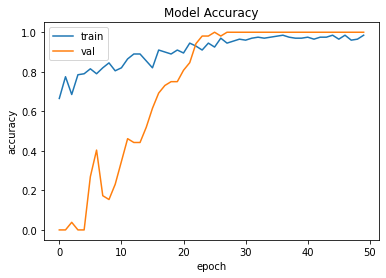

In [0]:
plt.plot(cnnhist.history['acc'])
plt.plot(cnnhist.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

Loss Comparison

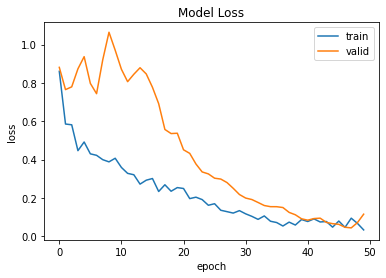

In [0]:
plt.plot(cnnhist.history['loss'])
plt.plot(cnnhist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

Confusion Matrix

[[52  0]
 [ 0  0]]


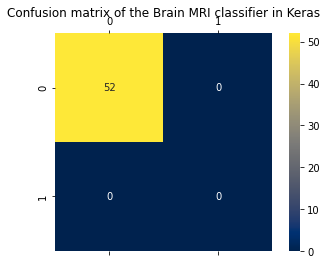

In [0]:
predictions = cnn_model.predict(x_test)
predictions = [1 if x>0.5 else 0 for x in predictions]
labels = [0, 1]
cm = confusion_matrix(y_test, predictions, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the Brain MRI classifier in Keras')
#fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
sns.heatmap(cm,annot=True,cmap="cividis")
plt.show()

Plotting brain image samples of 20 test images with their prediction and ground truth

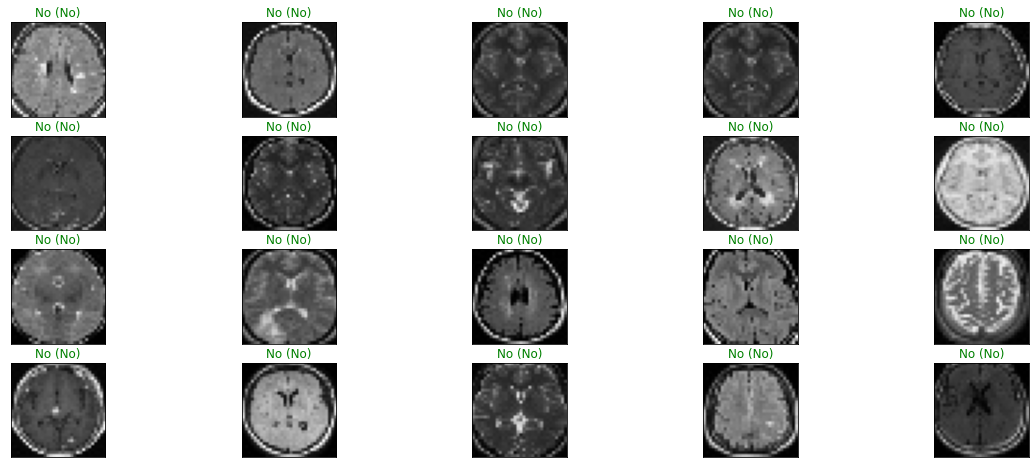

In [0]:
labels =["No",  # index 1
        "Yes", ]  # index 0
y_pred = cnn_model.predict(x_test)
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=20, replace=False)):
    ax = figure.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_pred[index])
    true_index = np.argmax(y_test[index])
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()